# VRPTW - SPEA

### Definición del problema

In [ ]:
def calcular_distancia(customer1, customer2):
    return math.sqrt((customer1['coord']['x'] - customer2['coord']['x'])**2 + (customer1['coord']['y'] - customer2['coord']['y'])**2)

In [ ]:
def preprocesamiento(file):
    text_file = f'{file}.txt'
    data = {}
    with io.open(text_file, 'rt', encoding='utf-8', newline='') as file_object:
        for line_count, line in enumerate(file_object, start=1):
            if line_count in [1, 3, 5]:
                pass
            elif line_count == 2:
                values = line.strip().split()
                data['customers'] = int(values[0])
            elif line_count == 4:
                values = line.strip().split()
                data['vehicle_capacity'] = float(values[0])
            elif line_count == 6:
                values = line.strip().split()
                data['origin'] = {
                    'coord': {
                        'x': float(values[1]),
                        'y': float(values[2]),
                    },
                    'demand': float(values[3]),
                    'ready_time': float(values[4]),
                    'due_time': float(values[5]),
                    'service_time': float(values[6]),
                }
            else:
                values = line.strip().split()
                data[f'cust_{values[0]}'] = {
                    'coord': {
                        'x': float(values[1]),
                        'y': float(values[2]),
                    },
                    'demand': float(values[3]),
                    'ready_time': float(values[4]),
                    'due_time': float(values[5]),
                    'service_time': float(values[6]),
                }
    customers = ['origin'] + [f'cust_{x}' for x in range(1, 101)]
    data['distance_matrix'] = [[calcular_distancia(data[customer1], data[customer2]) for customer1 in customers] for customer2 in customers]
    return data

In [ ]:
def individuoRuta(individuo, instancia):
    ruta = []
    capacidad = instancia['vehicle_capacity']
    tiempo_limite = instancia['origin']['due_time']
    for cust_id in individuo:
        instancia[f'cust_{cust_id}']['visited'] = 0
    while todosVisitados(individuo, instancia) == False:
        sub_ruta = []
        carga_vehiculo = 0
        tiempo_transcurrido = 0
        ultimo_cust_id = 0
        for cust_id in individuo:
            if instancia[f'cust_{cust_id}']['visited'] != 1:
                distancia = instancia['distance_matrix'][ultimo_cust_id][cust_id]
                demanda = instancia[f'cust_{cust_id}']['demand']
                carga_actual = carga_vehiculo + demanda
                tiempo_llegada = tiempo_transcurrido + distancia
                tiempo_espera = max(instancia[f'cust_{cust_id}']['ready_time'] - tiempo_llegada, 0)
                tiempo_servicio = instancia[f'cust_{cust_id}']['service_time']
                if carga_actual > capacidad:
                    continue
                if tiempo_llegada + tiempo_servicio > instancia[f'cust_{cust_id}']['due_time']:
                    continue
                sub_ruta.append(cust_id)
                carga_vehiculo += demanda
                tiempo_transcurrido = tiempo_llegada + tiempo_espera + tiempo_servicio
                instancia[f'cust_{cust_id}']['visited'] = 1
                ultimo_cust_id = cust_id
        if sub_ruta != []:
                ruta.append(sub_ruta)
    return ruta

def todosVisitados(individuo, instancia):
    count = 0
    for cust_id in individuo:
        if instancia[f'cust_{cust_id}']['visited'] == 1:
            count += 1
    return count == len(individuo)

### Implementación del problema

In [ ]:
def evaluacion(individuo, instancia):
    costo_total = 0
    cantidad_vehiculo = 0
    ruta = individuoRuta(individuo, instancia)
    for sub_ruta in ruta:
        cantidad_vehiculo += 1
        distancia_subruta = 0
        ultimo_cust_id = 0
        for cust_id in sub_ruta:
            distancia = instancia['distance_matrix'][ultimo_cust_id][cust_id]
            distancia_subruta += distancia
            ultimo_cust_id = cust_id
        distancia_subruta += instancia['distance_matrix'][ultimo_cust_id][0]
        costo_subruta = distancia_subruta
        costo_total += costo_subruta
    return costo_total, cantidad_vehiculo

def cobertura(x, y):
    if (x['costo_total'] <= y['costo_total'] and x['cantidad_vehiculo'] <= y['cantidad_vehiculo']):
        return True
    else:
        return False

def determinarDf(a):
    df = pd.DataFrame({"costo_total": [x['costo_total'] for x in a], 
                       "cantidad_vehiculo": [x['cantidad_vehiculo'] for x in a]})
    return df

def solucionesNoDominadas(a):
    aux = a.copy()
    pobDf = determinarDf(aux)
    mascara = paretoset(pobDf, sense=["min", "min"])
    solucion = [x for (x, m) in zip(aux, mascara) if m]
    return solucion

def union(a, b):
    c = [x for x in a]
    d = [y for y in b if y not in c]
    return c + d

def asignacionFitness(poblacion, pareto, instancia, gen):
    for ind in poblacion:
        ind['costo_total'], ind['cantidad_vehiculo'] = evaluacion(ind['ruta'], instancia)
    A = solucionesNoDominadas(poblacion)
    B = union(pareto, A)
    pareto = solucionesNoDominadas(B)
    for paretoInd in pareto:
        count = 0
        for pobInd in poblacion:
            if cobertura(paretoInd, pobInd):
                count += 1
        peso = float(count / (len(poblacion) + 1))
        paretoInd['fitness'] = peso
    for pobInd in poblacion:
        suma = 0.0
        for paretoInd in pareto:
            if cobertura(paretoInd, pobInd):
                suma = suma + paretoInd['fitness']
        pobInd['fitness'] = suma + 1
    return poblacion, pareto

In [ ]:
def inicializarIndividuo(x):
    individuo = {}
    individuo['ruta'] = random.sample(range(1, x), x-1)
    individuo['fitness'] = float("inf")
    return individuo

In [ ]:
def torneoBinario(a):
    if len(a) != 1:
        ganador = random.sample(a, k = 2)
        ganador = sorted(ganador, key=lambda x: x['fitness'])
        a.remove(ganador[0])
        return ganador[0]
    else:
        return a[0]

def dosPuntos(p, a, b, subHijo1, subHijo2):
    for i in range(p[0], p[1]):
        subHijo1.append(a['ruta'][i])
    subHijo2 = [x for x in b['ruta'] if x not in subHijo1]

def crossover(a, b):
    c, d = a.copy(), b.copy()
    subHijo1 = []
    subHijo2 = []
    p = random.sample(range(1, len(a['ruta']) - 1), 2)
    p = sorted(p)
    dosPuntos(p, a, b, subHijo1, subHijo2)
    c['ruta'] = subHijo1 + subHijo2
    subHijo1.clear()
    subHijo2.clear()
    dosPuntos(p, b, a, subHijo1, subHijo2)
    d['ruta'] = subHijo1 + subHijo2
    return c, d

def mutar(mutante):
    i = random.randint(0, len(mutante['ruta'])-1)
    j = random.randint(0, len(mutante['ruta'])-1)
    cliente1 = mutante['ruta'][i]
    cliente2 = mutante['ruta'][j]
    mutante['ruta'][i] = cliente2
    mutante['ruta'][j] = cliente1
    return mutante

In [ ]:
def spea(poblacion, pareto, instancia, m=100, c_pbb=0.8, m_pbb=0.3, generaciones=100):
    for x in range(m):
        poblacion.append(inicializarIndividuo(instancia['customers']))
    for gen in trange(generaciones, desc="Generaciones", unit="gen"):
        poblacion, pareto = asignacionFitness(poblacion, pareto, instancia, gen)
        if (gen != generaciones - 1):
            u = union(poblacion, pareto)
            descendientes = [torneoBinario(u) for _ in range(m)]
            for a, b in zip(descendientes[::2], descendientes[1::2]):
                if random.random() < c_pbb:
                    a, b = crossover(a, b)
                    a['fitness'], b['fitness'] = float("inf"), float("inf")
            for mutante in descendientes:
                if random.random() < m_pbb:
                    mutante = mutar(mutante)
                    mutante['fitness'] = float("inf")
            poblacion = descendientes
    return poblacion, pareto

In [ ]:
def graficar_spea(poblacion, pareto, save=None):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot([s['costo_total'] for s in poblacion],
            [s['cantidad_vehiculo'] for s in poblacion],
            'bo',
            label="Soluciones")

    ax.plot([s['costo_total'] for s in pareto],
            [s['cantidad_vehiculo'] for s in pareto],
            'ro',
            label="Pareto Set")

    ax.set(xlabel="Tiempo de viaje",
           ylabel="Nº de Vehículos",
           title="Frente Pareto (SPEA)")
    ax.yaxis.set_major_locator(ticker.MultipleLocator())
    ax.legend(loc='upper right')

    if save:
        os.makedirs("figs", exist_ok=True)
        plt.savefig(f"figs/{save}")

Generaciones:   0%|          | 0/100 [00:00<?, ?gen/s]

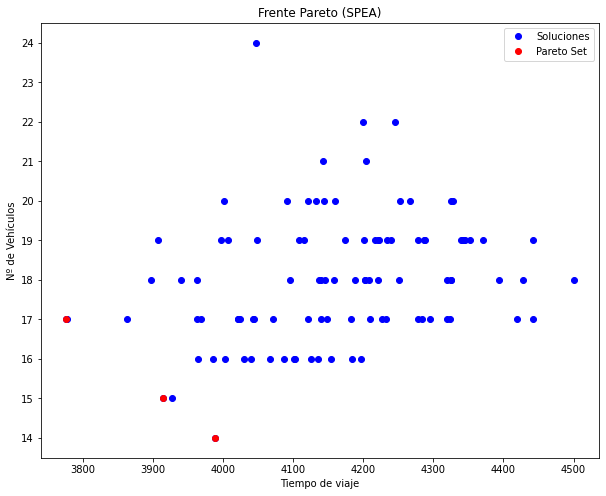

In [31]:
archivo = preprocesamiento('vrptw_c101')

pob = []
par = []

pob, par = spea(pob, par, archivo, m=100, c_pbb=0.8, m_pbb=0.3, generaciones=100)

graficar_spea(pob, par, save="ParetoSetSPEA.jpg")